## Dataset Preprocessing

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

### Train/Validation/Test Split

In [3]:
# Paths
base_dir = './allpicture'
autistic_dir = os.path.join(base_dir, 'autistic')
nonautistic_dir = os.path.join(base_dir, 'nonautistic')

# Collecting file paths
autistic_files = [os.path.join(autistic_dir, f) for f in os.listdir(autistic_dir) if os.path.isfile(os.path.join(autistic_dir, f))]
nonautistic_files = [os.path.join(nonautistic_dir, f) for f in os.listdir(nonautistic_dir) if os.path.isfile(os.path.join(nonautistic_dir, f))]

# Assigning labels
files = autistic_files + nonautistic_files
labels = [1] * len(autistic_files) + [0] * len(nonautistic_files)

# Splitting data
train_files, test_files, train_labels, test_labels = train_test_split(files, labels, test_size=0.30, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels, test_size=0.3333, random_state=42)

# Function to copy files to a new directory
def copy_files(files, labels, dest_folder):
    for f, label in zip(files, labels):
        label_folder = os.path.join(dest_folder, 'autistic' if label == 1 else 'nonautistic')
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        shutil.copy(f, label_folder)

# Creating directories for the datasets
os.makedirs('./train1', exist_ok=True)
os.makedirs('./val1', exist_ok=True)
os.makedirs('./test1', exist_ok=True)

# Copying files
copy_files(train_files, train_labels, './train1')
copy_files(val_files, val_labels, './val1')
copy_files(test_files, test_labels, './test1')


### Resizing Normalizing and Grayscaling

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Define the ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Prepare data generators with the correct color_mode
train_generator = train_datagen.flow_from_directory(
    './train1',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'  # Correct place for color_mode
)

validation_generator = val_test_datagen.flow_from_directory(
    './val1',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'  # Correct place for color_mode
)

test_generator = val_test_datagen.flow_from_directory(
    './test1',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'  # Correct place for color_mode
)


Found 2048 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 293 images belonging to 2 classes.


### Preview after processing

Training Set:


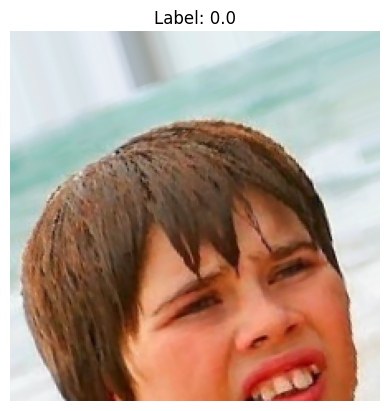

Validation Set:


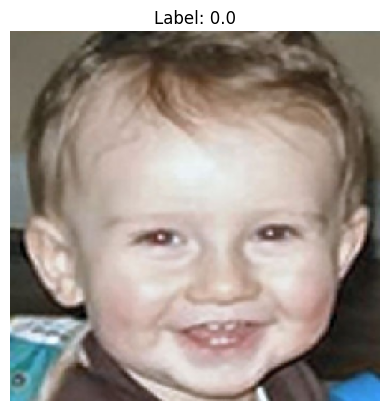

Testing Set:


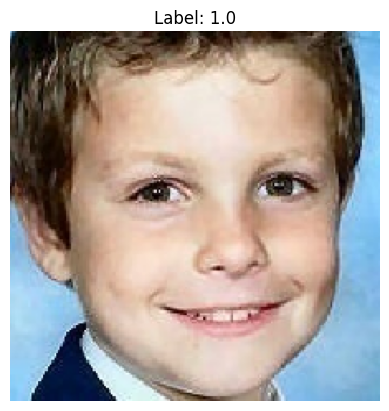

In [6]:
import matplotlib.pyplot as plt

def show_preprocessed_image(generator):
    # Get a batch of data
    images, labels = next(generator)
    
    # Display the first image in the batch
    plt.imshow(images[0].squeeze(), cmap='gray' if images[0].shape[-1] == 1 else None)
    plt.title(f"Label: {labels[0]}")
    plt.axis('off')
    plt.show()

# Show one preprocessed image from each set
print("Training Set:")
show_preprocessed_image(train_generator)

print("Validation Set:")
show_preprocessed_image(validation_generator)

print("Testing Set:")
show_preprocessed_image(test_generator)


## CNN Building

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

# Load pre-trained VGG16 model, excluding its top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x) # Single neuron for binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## Callback Settings

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

# Callback for F1 Score and ROC AUC
class CustomMetrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_f1s = []
        self.train_roc_aucs = []
        self.val_f1s = []
        self.val_roc_aucs = []

    def on_epoch_end(self, epoch, logs={}):
        # Predictions for training set
        train_pred = (np.asarray(self.model.predict(self.train_data[0]))).round()
        train_targ = self.train_data[1]

        # Predictions for validation set
        val_pred = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]

        # Calculate F1 Score and ROC AUC for training set
        _train_f1 = f1_score(train_targ, train_pred)
        _train_roc_auc = roc_auc_score(train_targ, train_pred)

        # Calculate F1 Score and ROC AUC for validation set
        _val_f1 = f1_score(val_targ, val_pred)
        _val_roc_auc = roc_auc_score(val_targ, val_pred)

        self.train_f1s.append(_train_f1)
        self.train_roc_aucs.append(_train_roc_auc)
        self.val_f1s.append(_val_f1)
        self.val_roc_aucs.append(_val_roc_auc)

        print(f" — train_f1: {_train_f1} — train_roc_auc: {_train_roc_auc} — val_f1: {_val_f1} — val_roc_auc: {_val_roc_auc}")

        return

# Callback for checkpointing
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Instantiate custom metrics callback
metrics_callback = CustomMetrics()
metrics_callback.train_data = (train_generator[0][0], train_generator[0][1])
metrics_callback.validation_data = (validation_generator[0][0], validation_generator[0][1])

# Training the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, metrics_callback]
)

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 1.3558 - accuracy: 0.6211
Epoch 1: val_loss improved from inf to 0.49341, saving model to best_model.h5


C:\Users\24212\anaconda3\envs\sta160\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
 — train_f1: 0.8333333333333334 — train_roc_auc: 0.8125 — val_f1: 0.6923076923076923 — val_roc_auc: 0.7662337662337664
64/64 [==============================] - 171s 3s/step - loss: 1.3558 - accuracy: 0.6211 - val_loss: 0.4934 - val_accuracy: 0.7556
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.5824 - accuracy: 0.6938
Epoch 2: val_loss improved from 0.49341 to 0.47539, saving model to best_model.h5


C:\Users\24212\anaconda3\envs\sta160\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
 — train_f1: 0.8125 — train_roc_auc: 0.8125 — val_f1: 0.7500000000000001 — val_roc_auc: 0.8138528138528139
64/64 [==============================] - 170s 3s/step - loss: 0.5824 - accuracy: 0.6938 - val_loss: 0.4754 - val_accuracy: 0.7795
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.5694 - accuracy: 0.7163
Epoch 3: val_loss did not improve from 0.47539
1/1 [==============================] - 2s 2s/step
 — train_f1: 0.875 — train_roc_auc: 0.875 — val_f1: 0.7272727272727273 — val_roc_auc: 0.7922077922077922
64/64 [==============================] - 172s 3s/step - loss: 0.5694 - accuracy: 0.7163 - val_loss: 0.4866 - val_accuracy: 0.7829
Epoch 4/100
64/64 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7256
Epoch 4: val_loss did not improve from 0.47539
1/1 [==============================] - 2s 2s/step
 — train_f1: 0.8205128205128205 — train_roc_auc: 0.78125 — val_f1: 0.6875000000000001 — val_ro

C:\Users\24212\anaconda3\envs\sta160\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
 — train_f1: 0.8387096774193549 — train_roc_auc: 0.84375 — val_f1: 0.631578947368421 — val_roc_auc: 0.7251082251082251
64/64 [==============================] - 171s 3s/step - loss: 0.5386 - accuracy: 0.7158 - val_loss: 0.4695 - val_accuracy: 0.7624
Epoch 6/100
64/64 [==============================] - ETA: 0s - loss: 0.5354 - accuracy: 0.7266
Epoch 6: val_loss improved from 0.46949 to 0.45072, saving model to best_model.h5


C:\Users\24212\anaconda3\envs\sta160\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
 — train_f1: 0.8387096774193549 — train_roc_auc: 0.84375 — val_f1: 0.6666666666666666 — val_roc_auc: 0.7467532467532467
64/64 [==============================] - 175s 3s/step - loss: 0.5354 - accuracy: 0.7266 - val_loss: 0.4507 - val_accuracy: 0.7812
Epoch 7/100
64/64 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.7324
Epoch 7: val_loss did not improve from 0.45072
1/1 [==============================] - 2s 2s/step
 — train_f1: 0.8275862068965517 — train_roc_auc: 0.84375 — val_f1: 0.631578947368421 — val_roc_auc: 0.7251082251082251
64/64 [==============================] - 175s 3s/step - loss: 0.5249 - accuracy: 0.7324 - val_loss: 0.4670 - val_accuracy: 0.7812
Epoch 8/100
64/64 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.7466
Epoch 8: val_loss did not improve from 0.45072
1/1 [==============================] - 2s 2s/step
 — train_f1: 0.7999999999999999 — train_roc_auc: 0.8125 — val_f1: 0

C:\Users\24212\anaconda3\envs\sta160\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
 — train_f1: 0.7999999999999999 — train_roc_auc: 0.8125 — val_f1: 0.631578947368421 — val_roc_auc: 0.7251082251082251
64/64 [==============================] - 173s 3s/step - loss: 0.5074 - accuracy: 0.7534 - val_loss: 0.4471 - val_accuracy: 0.7675
Epoch 10/100
64/64 [==============================] - ETA: 0s - loss: 0.5044 - accuracy: 0.7578
Epoch 10: val_loss improved from 0.44706 to 0.43796, saving model to best_model.h5


C:\Users\24212\anaconda3\envs\sta160\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
 — train_f1: 0.7999999999999999 — train_roc_auc: 0.8125 — val_f1: 0.631578947368421 — val_roc_auc: 0.7251082251082251
64/64 [==============================] - 175s 3s/step - loss: 0.5044 - accuracy: 0.7578 - val_loss: 0.4380 - val_accuracy: 0.7880
Epoch 11/100
64/64 [==============================] - ETA: 0s - loss: 0.5074 - accuracy: 0.7563
Epoch 11: val_loss did not improve from 0.43796
1/1 [==============================] - 2s 2s/step
 — train_f1: 0.8275862068965517 — train_roc_auc: 0.84375 — val_f1: 0.631578947368421 — val_roc_auc: 0.7251082251082251
64/64 [==============================] - 169s 3s/step - loss: 0.5074 - accuracy: 0.7563 - val_loss: 0.4448 - val_accuracy: 0.7744
Epoch 12/100
64/64 [==============================] - ETA: 0s - loss: 0.4914 - accuracy: 0.7666
Epoch 12: val_loss improved from 0.43796 to 0.42337, saving model to best_model.h5


C:\Users\24212\anaconda3\envs\sta160\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
 — train_f1: 0.8571428571428572 — train_roc_auc: 0.84375 — val_f1: 0.6666666666666667 — val_roc_auc: 0.7445887445887445
64/64 [==============================] - 168s 3s/step - loss: 0.4914 - accuracy: 0.7666 - val_loss: 0.4234 - val_accuracy: 0.8085
Epoch 13/100
64/64 [==============================] - ETA: 0s - loss: 0.5038 - accuracy: 0.7358
Epoch 13: val_loss did not improve from 0.42337
1/1 [==============================] - 2s 2s/step
 — train_f1: 0.8666666666666666 — train_roc_auc: 0.875 — val_f1: 0.5263157894736842 — val_roc_auc: 0.6558441558441559
64/64 [==============================] - 168s 3s/step - loss: 0.5038 - accuracy: 0.7358 - val_loss: 0.4551 - val_accuracy: 0.7692
Epoch 14/100
64/64 [==============================] - ETA: 0s - loss: 0.4914 - accuracy: 0.7573
Epoch 14: val_loss did not improve from 0.42337
1/1 [==============================] - 2s 2s/step
 — train_f1: 0.8275862068965517 — train_roc_auc: 0.84375 — val_f

In [34]:
# Load the best model
model.load_weights("best_model.h5")

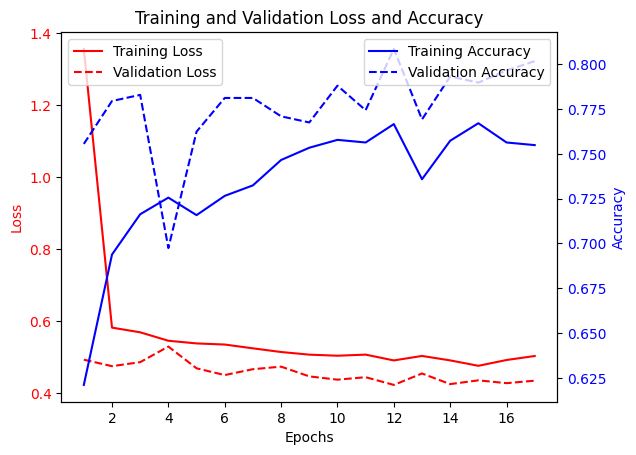

In [32]:
import matplotlib.pyplot as plt

# Make sure you have the 'history' object from your model training
# history = model.fit(...)

epochs = range(1, len(history.history['loss']) + 1)

# Creating plot
fig, ax1 = plt.subplots()

# Plotting training and validation loss
ax1.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
ax1.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Creating a second y-axis for the accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
ax2.plot(epochs, history.history['val_accuracy'], 'b--', label='Validation Accuracy')
ax2.set_ylabel('Accuracy', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adding title
plt.title('Training and Validation Loss and Accuracy')

# Show plot
plt.show()


In [35]:
# Assuming `model` is your CNN model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the input tensor
input_tensor = Input(shape=(224, 224, 3))

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_tensor)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

# Flatten and add Dense layers with Dropout and L2 regularization
x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='fc1', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5, name='dropout1')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

# Create the model
model2 = Model(inputs=input_tensor, outputs=x, name='model_2')

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# View the structure of the model
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0   

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

# Callback for F1 Score and ROC AUC
class CustomMetrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_f1s = []
        self.train_roc_aucs = []
        self.val_f1s = []
        self.val_roc_aucs = []

    def on_epoch_end(self, epoch, logs={}):
        # Predictions for training set
        train_pred = (np.asarray(self.model.predict(self.train_data[0]))).round()
        train_targ = self.train_data[1]

        # Predictions for validation set
        val_pred = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]

        # Calculate F1 Score and ROC AUC for training set
        _train_f1 = f1_score(train_targ, train_pred)
        _train_roc_auc = roc_auc_score(train_targ, train_pred)

        # Calculate F1 Score and ROC AUC for validation set
        _val_f1 = f1_score(val_targ, val_pred)
        _val_roc_auc = roc_auc_score(val_targ, val_pred)

        self.train_f1s.append(_train_f1)
        self.train_roc_aucs.append(_train_roc_auc)
        self.val_f1s.append(_val_f1)
        self.val_roc_aucs.append(_val_roc_auc)

        print(f" — train_f1: {_train_f1} — train_roc_auc: {_train_roc_auc} — val_f1: {_val_f1} — val_roc_auc: {_val_roc_auc}")

        return

# Callback for checkpointing
checkpoint2 = ModelCheckpoint("best_model2.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Instantiate custom metrics callback
metrics_callback = CustomMetrics()
metrics_callback.train_data = (train_generator[0][0], train_generator[0][1])
metrics_callback.validation_data = (validation_generator[0][0], validation_generator[0][1])

# Training the model
history = model2.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint2, early_stopping, metrics_callback]
)

Epoch 1/100


64/64 [==============================] - ETA: 0s - loss: 13.5197 - accuracy: 0.6040 
Epoch 1: val_loss improved from inf to 10.55462, saving model to best_model2.keras
1/1 [==============================] - 2s 2s/step
 — train_f1: 0.45161290322580644 — train_roc_auc: 0.5303030303030303 — val_f1: 0.3157894736842105 — val_roc_auc: 0.5515873015873015
64/64 [==============================] - 704s 11s/step - loss: 13.5197 - accuracy: 0.6040 - val_loss: 10.5546 - val_accuracy: 0.5590
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 3.7114 - accuracy: 0.6191
Epoch 2: val_loss improved from 10.55462 to 3.39768, saving model to best_model2.keras
1/1 [==============================] - 2s 2s/step
 — train_f1: 0.7804878048780488 — train_roc_auc: 0.699134199134199 — val_f1: 0.6206896551724138 — val_roc_auc: 0.6547619047619049
64/64 [==============================] - 685s 11s/step - loss: 3.7114 - accuracy: 0.6191 - val_loss: 3.3977 - val_accuracy: 0.5333
Epoch 3/10